In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.formula.api as smf


In [2]:
def clean_daily_data(df, columns, pid_name, date_name):
    """
    df: the dataframe with samples
    columns: should be a dictionary, with the columns to filter and the filter values, i.e. {'resting_heart_rate': (20,200)}
    pid_name: name of the pid column
    date_name: name of the date column, assumed not to already be datetime based
    """

    df['pid'] = df[pid_name]
    # Make sure dates are in pandas datetime
    df['date'] = pd.to_datetime(df[date_name])
    
    # Set a multi-index on PID and date
    df = df.set_index(['pid', 'date']).sort_index()

    # Iterate through the set of columns to filter on
    for key, values in columns.items():
        df = df[df[key].between(values[0], values[1])]
        
    # Resample to daily, important for lagged-z-scoring
    df = df.groupby('pid').apply(lambda x: x.droplevel(0).resample('D').asfreq())

    df['day_of_week'] = df.index.get_level_values(1).dayofweek
    
    return df

    

# Load data

In [ ]:
homekit_nightly = pd.read_csv('/homekit2020neurips/fitbit_day_level_activity.csv', index_col=0)

columns = {
    'resting_heart_rate': (20, 200),
    'caloriesOut': (500, 20000),
    'total_asleep_minutes': (60, 16*60*60),
}

homekit_nightly = clean_daily_data(homekit_nightly, columns, 'participant_id', 'date')

In [3]:
# COVID-RED
covid_red_nightly = pd.read_csv('./data/wd_20230515.csv')

columns = {
    'WDTEMP': (0, 45),
    'WDPULSE': (20, 200),
    'WDSLEEP': (60, 16*60*60),
}

covid_red_nightly = clean_daily_data(covid_red_nightly, columns, 'SUBJID', 'WDDT')

In [4]:
# COVID-Dataspende
corona_dataspende_nightly = pd.read_csv('./data/Corona-Datenspende_Teildatensatz_Vitaldaten.tsv', delimiter= '\t')

columns = {
    'heartrate_mean': (20, 200),
    'sleep_duration_mean': (1, 16*60),
}
corona_dataspende_nightly = clean_daily_data(corona_dataspende_nightly, columns, 'nuts_code', 'date')

# Only concerned with DE
corona_dataspende_nightly = corona_dataspende_nightly.loc['DE']

In [6]:
def get_iso_format_means(df, iso_feature, short_year_wrap, wrap_week):
    df_iso = df.reset_index().copy()[[iso_feature, 'date']].dropna()
    df_iso[['year', 'week', 'day']] = df_iso['date'].dt.isocalendar()
    df_iso['year'] = 2020
    if short_year_wrap:
        df_iso.loc[df_iso[df_iso['week'] > wrap_week].index, 'year'] = 2019
    
    df_iso['date'] = df_iso['year'].astype(str) + '-' + df_iso['week'].apply(lambda x: f"{x:02}") + '-' + df_iso['day'].astype(str)
    df_iso_groupby_mean = df_iso.groupby('date')[iso_feature].mean()
    df_iso_groupby_mean.index = pd.to_datetime(df_iso_groupby_mean.reset_index()['date'], format = '%G-%V-%u')
    return df_iso_groupby_mean

In [7]:
homekit_nightly_iso_groupby_mean = get_iso_format_means(homekit_nightly, 'resting_heart_rate', True, 28)


In [7]:
covid_red_nightly_iso_groupby_mean = get_iso_format_means(covid_red_nightly, 'WDPULSE', False, _)
corona_dataspende_nightly_iso_groupby_mean = get_iso_format_means(corona_dataspende_nightly, 'heartrate_mean', False, _)

In [8]:
all_of_us_nightly_iso_groupby_mean = pd.read_csv('./data/all_of_us_iso_hr_mean.csv')
all_of_us_nightly_iso_groupby_mean['date'] = pd.to_datetime(all_of_us_nightly_iso_groupby_mean['date']).values
all_of_us_nightly_iso_groupby_mean['day_of_week'] = all_of_us_nightly_iso_groupby_mean['date'].dt.dayofweek
all_of_us_nightly_iso_groupby_mean = all_of_us_nightly_iso_groupby_mean.set_index('date')
all_of_us_nightly_iso_groupby_mean

,index,PERSON_ID,avg_heart_rate,year,week,day,day_of_week
date,,,,,,,
2019-12-30,5.603643e+06,3.148285e+06,66.858244,2020.0,1.0,1.0,0
2019-12-31,5.583804e+06,3.156199e+06,66.868137,2020.0,1.0,2.0,1
2020-01-01,5.563108e+06,3.151511e+06,66.840345,2020.0,1.0,3.0,2
2020-01-02,5.604791e+06,3.149122e+06,66.927396,2020.0,1.0,4.0,3
2020-01-03,5.594342e+06,3.141219e+06,66.836418,2020.0,1.0,5.0,4
...,...,...,...,...,...,...,...
2020-12-30,5.581426e+06,3.246898e+06,66.613489,2020.0,53.0,3.0,2
2020-12-31,5.589576e+06,3.237149e+06,66.755728,2020.0,53.0,4.0,3
2021-01-01,5.600295e+06,3.240736e+06,66.701391,2020.0,53.0,5.0,4


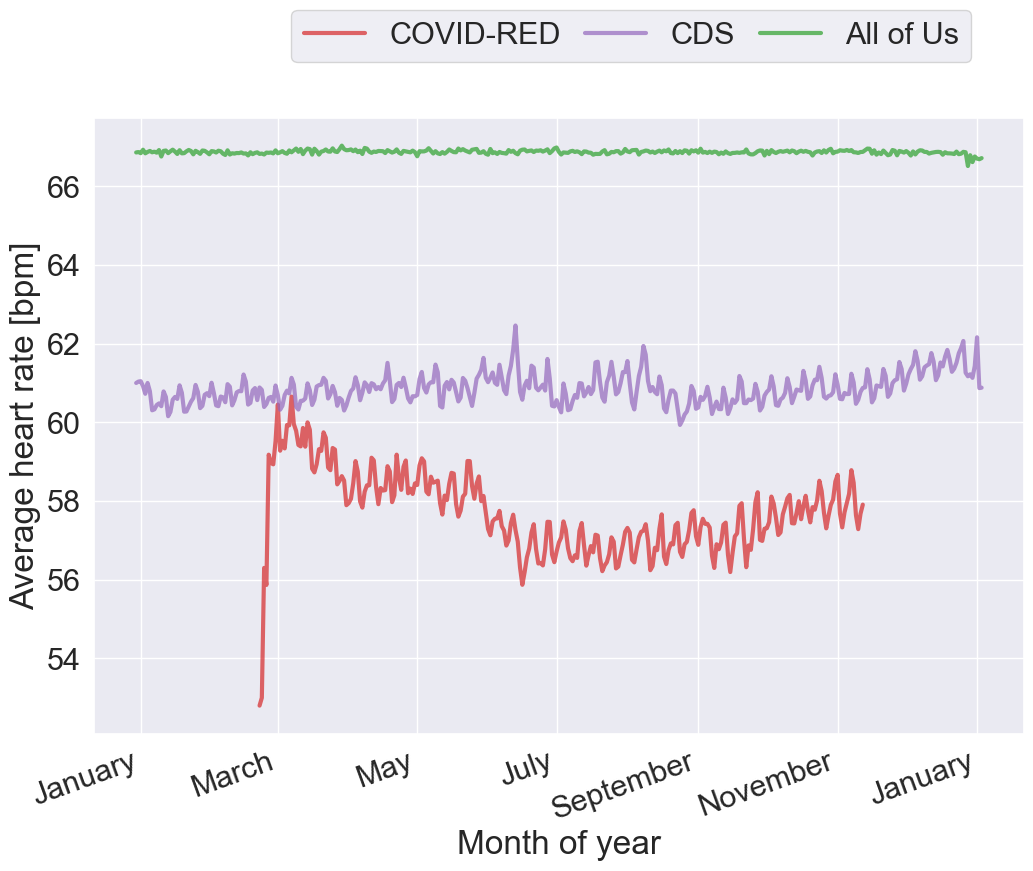

In [9]:
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 20})
sns.set_theme()
sns.set_theme(font_scale = 2)

plt.close('all')
fig, axes = plt.subplots(1, 1, figsize = (12,8))

overall_linewidth = 3

"""
g1 = sns.lineplot(
    data = homekit_nightly_iso_groupby_mean, 
     **{'linewidth':overall_linewidth}, ax = axes, color = 'tab:blue', alpha = 0.7, label = 'Homekit2020')
"""

g3 = sns.lineplot(
    data = covid_red_nightly_iso_groupby_mean,
     **{'linewidth':overall_linewidth}, ax = axes, color = 'tab:red', alpha = 0.7, label = 'COVID-RED')

g4 = sns.lineplot(
    data = corona_dataspende_nightly_iso_groupby_mean,
     **{'linewidth':overall_linewidth}, ax = axes, color = 'tab:purple', alpha = 0.7, label = 'CDS')

g5 = sns.lineplot(
    data = all_of_us_nightly_iso_groupby_mean['avg_heart_rate'],
     **{'linewidth':overall_linewidth}, ax = axes, color = 'tab:green', alpha = 0.7, label = 'All of Us')


axes.set(xlabel = "Month of year", ylabel = 'Average heart rate [bpm]')
axes.xaxis.set_major_formatter(DateFormatter('%B'))

for label in axes.get_xticklabels():
    label.set_rotation(20)
    label.set_ha('right')

handles, labels = axes.get_legend_handles_labels()

axes.legend(
    handles = handles,
    labels = labels,
    bbox_to_anchor=(.96, 1.2),
    title= None,
    prop={'size': 22},
    ncol=3,
    columnspacing=0.8
)

plt.show()

# Z-scored Iso plots

In [10]:
def z_score_modalities(df, modalities, length, min_num, offset, pid_name):
    """
    Inputs:
    df: a pandas dataframe, multi-indexed by pid and date
    modalities: iterable of strings, should be the names of columns
    length: the length of the window to z-score by
    min_num: the minumum number of non-missing days in the baseline period
    offset: how many days lagged to start the baseline period
    pid_name: the name of the index level with the pids
    """
    
    grouped_mean = df.groupby(pid_name)[modalities].rolling(window = length, min_periods = min_num).mean().shift(offset)
    grouped_std = df.groupby(pid_name)[modalities].rolling(window = length, min_periods = min_num).std().shift(offset)

    z_modality_names = [mod + "_z" for mod in modalities]
    df[z_modality_names] = (df[modalities].values - grouped_mean.values)/grouped_std.values
    return df

In [ ]:
homekit_nightly_z = z_score_modalities(homekit_nightly, ['resting_heart_rate'], 10, 6, 12, 'pid')


In [12]:
covid_red_nightly_z = z_score_modalities(covid_red_nightly, ['WDPULSE'], 10, 6, 12, 'pid')

corona_dataspende_nightly = corona_dataspende_nightly.reset_index()
corona_dataspende_nightly['pid'] = 'DE'
corona_dataspende_nightly = corona_dataspende_nightly.set_index(['pid', 'date'])
corona_dataspende_nightly

corona_dataspende_nightly_z = z_score_modalities(corona_dataspende_nightly, ['heartrate_mean'], 10, 6, 12, 'pid')

In [12]:
homekit_nightly_iso_groupby_mean_z = get_iso_format_means(homekit_nightly_z, 'resting_heart_rate_z', True, 28)


In [13]:
covid_red_nightly_iso_groupby_mean_z = get_iso_format_means(covid_red_nightly_z, 'WDPULSE_z', False, _)
corona_dataspende_nightly_iso_groupby_mean_z = get_iso_format_means(corona_dataspende_nightly_z, 'heartrate_mean_z', False, _)

In [ ]:
all_of_us_nightly_iso_groupby_mean_z = pd.read_csv('./data/all_of_us_nightly_z_iso.csv')
all_of_us_nightly_iso_groupby_mean_z.index = pd.to_datetime(all_of_us_nightly_iso_groupby_mean_z['date'])

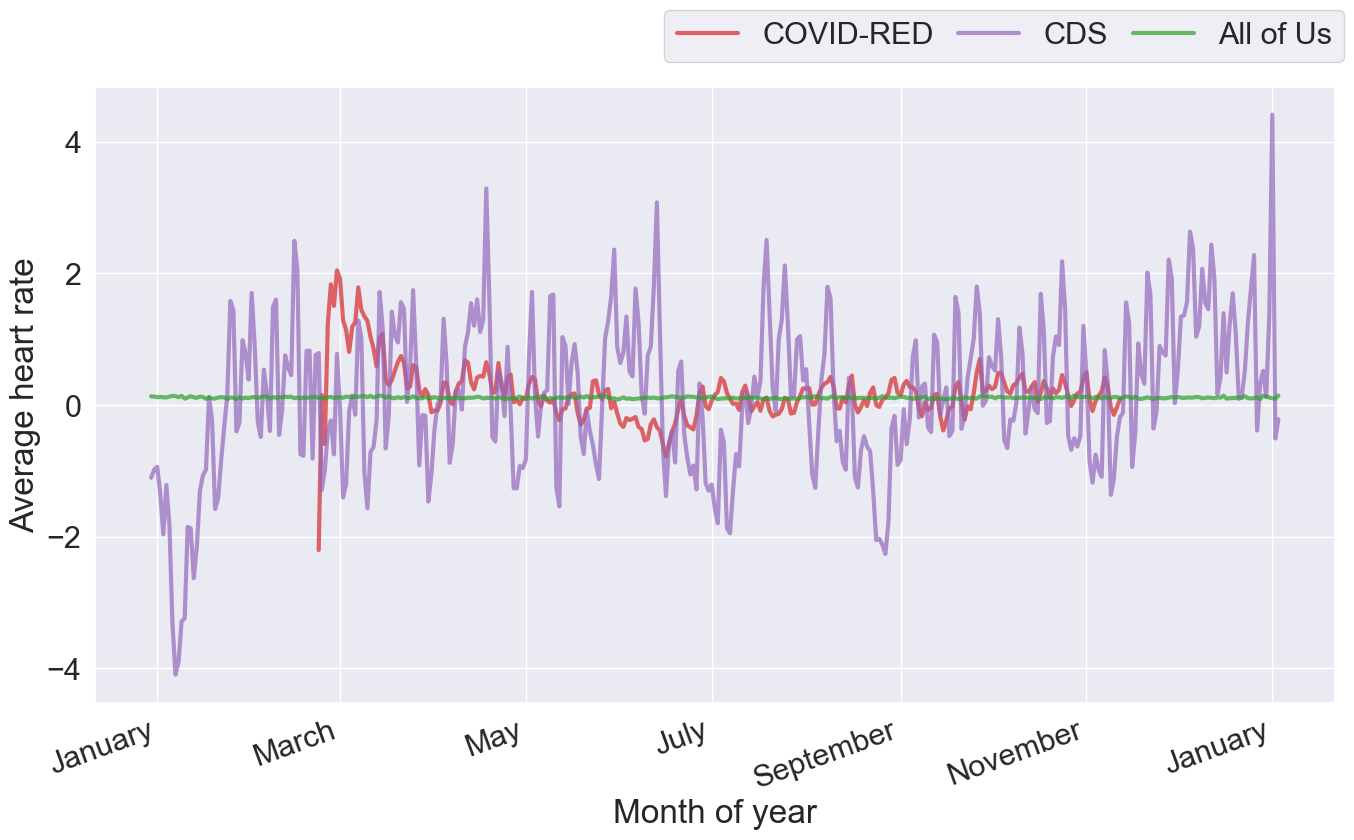

In [15]:
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 20})
sns.set_theme()
sns.set_theme(font_scale = 2)

plt.close('all')
fig, axes = plt.subplots(1, 1, figsize = (16,8))

overall_linewidth = 3

"""

g1 = sns.lineplot(
    data = homekit_nightly_iso_groupby_mean_z, 
     **{'linewidth':overall_linewidth}, ax = axes, color = 'tab:blue', alpha = 0.7, label = 'Homekit2020')
"""

g3 = sns.lineplot(
    data = covid_red_nightly_iso_groupby_mean_z,
     **{'linewidth':overall_linewidth}, ax = axes, color = 'tab:red', alpha = 0.7, label = 'COVID-RED')

g4 = sns.lineplot(
    data = corona_dataspende_nightly_iso_groupby_mean_z,
     **{'linewidth':overall_linewidth}, ax = axes, color = 'tab:purple', alpha = 0.7, label = 'CDS')

g5 = sns.lineplot(
    data = all_of_us_nightly_iso_groupby_mean_z['avg_heart_rate_z'],
     **{'linewidth':overall_linewidth}, ax = axes, color = 'tab:green', alpha = 0.7, label = 'All of Us')


axes.set(xlabel = "Month of year", ylabel = 'Average heart rate')
axes.xaxis.set_major_formatter(DateFormatter('%B'))

for label in axes.get_xticklabels():
    label.set_rotation(20)
    label.set_ha('right')

handles, labels = axes.get_legend_handles_labels()

axes.legend(
    handles = handles,
    labels = labels,
    bbox_to_anchor=(1.02, 1.15),
    title= None,
    prop={'size': 22},
    ncol=5,
    columnspacing=0.8
)

plt.show()

In [16]:
def calculate_weekend_effects(df, feature_name):
    weekend_map = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:1,
        6:1,
    }
    
    df['is_weekend'] = df['day_of_week'].map(weekend_map)
    return df[[feature_name, 'is_weekend']].groupby('is_weekend').mean().loc[1] - df[[feature_name, 'is_weekend']].groupby('is_weekend').mean().loc[0]


In [17]:
calculate_weekend_effects(corona_dataspende_nightly, 'heartrate_mean')

heartrate_mean    0.392736
dtype: float64

In [18]:
calculate_weekend_effects(covid_red_nightly, 'WDPULSE')

WDPULSE    0.615572
dtype: float64

In [19]:
calculate_weekend_effects(all_of_us_nightly_iso_groupby_mean, 'avg_heart_rate')

avg_heart_rate    0.005618
dtype: float64

In [20]:
overall_bins = ["<29", "30-39", "40-49", "50-59", "60-69", ">70"]

# Load COVID_RED
covid_red_demo = pd.read_csv('./data/dm_20230515.csv')
covid_red_demo['age_bins'] = covid_red_demo['DMAGE']
covid_red_demo['age_bins_contin'] = covid_red_demo['age_bins'].map(dict(zip(overall_bins, np.arange(len(overall_bins)))))

covid_red_sex_mapping = {
    '1': 'male',
    '0': 'female'
}

covid_red_demo['sex'] = covid_red_demo['DMSEX'].map(covid_red_sex_mapping)
covid_red_demo['participant_id'] = covid_red_demo['SUBJID']

In [19]:
# Load Homekit
hk_demographics_path = '/homekit2020neurips/screener_demographics.parquet'
hk_demos = pd.read_parquet(hk_demographics_path)
hk_demos['age'] = hk_demos['age'].astype(float)

bins = [0, 29, 39, 49, 59, 69, float('inf')]
labels = ["<29", "30-39", "40-49", "50-59", "60-69", ">70"]

hk_demos['age_bins'] = pd.cut(hk_demos['age'], bins=bins, labels=labels, right=False)
hk_demos['age_bins_contin'] = hk_demos['age_bins'].map(dict(zip(overall_bins, np.arange(len(overall_bins)))))
hk_demo_groupby = hk_demos.groupby(['age_bins', 'sex']).count()

race_mapper = {
    'race__0' : 'White',
    'race__1' : 'Black or African-American',
    'race__2' : 'Asian',
    'race__3' : 'American Indian or Alaska Native',
    'race__4' : 'Native Hawaiian or Other Pacific Islander',
    'race__5' : 'Other',
    'ethnicity': 'Hispanic/Latino (1), not Hispanic/Latino (0)' 
}

hk_demos = hk_demos.rename(race_mapper, axis = 1)

race_cols = ['White','Black or African-American','Asian','American Indian or Alaska Native','Native Hawaiian or Other Pacific Islander','Other']
hk_demos[race_cols] = hk_demos[race_cols].astype(int)

# Extract race from one-hot encoded columns
hk_demos['Race'] = hk_demos[race_cols].idxmax(axis=1)

# If a person has indicated multiple races, label them as "Mixed"
hk_demos['Race'][hk_demos[race_cols].sum(axis=1) > 1] = 'Mixed'

homekit_common_race_label_mapping = {
    'White': 'Caucasian, European, White',
    'Black or African-American': 'Black or African-American',
    'Asian': 'Asian',
    'American Indian or Alaska Native': 'Mixed/Others/Undeclared',
    'Native Hawaiian or Other Pacific Islander': 'Asian',
    'Other': 'Mixed/Others/Undeclared',
    'Mixed': 'Mixed/Others/Undeclared',
}

hk_demos['race_mapped'] = hk_demos['Race'].map(homekit_common_race_label_mapping)

hk_demos = hk_demos.set_index('participant_id')

homekit_groupby_race = hk_demos.groupby('Race').count()
homekit_groupby_common_race = hk_demos.groupby('race_mapped').count()

In [20]:
all_cols = ['age', 'age_bins_contin', 'race_mapped', 'sex', 'resting_heart_rate']
homekit_nightly_demo = homekit_nightly['resting_heart_rate'].groupby('pid').mean().to_frame().merge(hk_demos, right_index = True, left_index = True, how = 'outer')
homekit_nightly_demo = homekit_nightly_demo.rename(columns = {'resting_heart_rate':'heart_rate'})
homekit_nightly_demo['dataset'] = 'homekit'


In [21]:
all_cols = ['age_bins_contin', 'DMCOB', 'sex', 'WDPULSE']
covid_red_nightly_demo = (covid_red_nightly['WDPULSE'].groupby('pid').mean().to_frame()).merge(covid_red_demo.set_index('SUBJID'), right_index = True, left_index = True, how = 'outer')
covid_red_nightly_demo = covid_red_nightly_demo.rename(columns = {'WDPULSE':'heart_rate'})
covid_red_nightly_demo['dataset'] = 'covid_red'

In [23]:
all_cols = ['age', 'age_bins_contin', 'race_mapped', 'sex', 'resting_heart_rate']
hk_demo_sleep = homekit_nightly['resting_heart_rate'].groupby('pid').mean().to_frame().merge(hk_demos, right_index = True, left_index = True, how = 'outer')

md = smf.ols("resting_heart_rate ~ age + sex + C(race_mapped, Treatment(reference='Caucasian, European, White'))", hk_demo_sleep[all_cols].dropna())
mdf = md.fit()
mdf.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     resting_heart_rate   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     36.63
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           1.12e-43
Time:                        17:05:07   Log-Likelihood:                -17618.
No. Observations:                5022   AIC:                         3.525e+04
Df Residuals:                    5015   BIC:                         3.529e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         68.2958      0.459    148.941      0.000      67.397      69.195
sex[T.male]                                                                                       -3.5596      0.256    -13.925      0.000      -4.061      -3.058
sex[T.nonbinary]                                                                                   4.5515      2.563      1.776      0.076      -0.473       9.576
C(race_mapped, Treatment(reference='Caucasian, European, White'))[T.Asian]                        -0.0953      0.665     -0.143      0.886      -1.400       1.209
C(race_mapped, Treatment(reference='Caucasian, European, White'))[T.Black or African-American]     2.3634      0.617      3.833      0.000       1.155       3.572
C(race_mapped, Treatment(reference='Caucasian, European, White'))[T.Mixed/Others/Undeclared]       0.9367      0.539      1.737      0.082      -0.121       1.994
age                                                                                               -0.0137      0.011     -1.212      0.226      -0.036       0.008
==============================================================================
Omnibus:                       84.476   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.697
Skew:                           0.297   Prob(JB):                     2.02e-20
Kurtosis:                       3.283   Cond. No.                         899.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
all_cols = ['age_bins_contin', 'DMCOB', 'sex', 'WDPULSE']
covid_red_nightly_demo = (covid_red_nightly['WDPULSE'].groupby('pid').mean().to_frame()).merge(covid_red_demo.set_index('SUBJID'), right_index = True, left_index = True, how = 'outer')

md = smf.ols("WDPULSE ~ age_bins_contin + sex + DMCOB", covid_red_nightly_demo[all_cols].dropna())
mdf = md.fit()
mdf.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                WDPULSE   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     253.2
Date:                Mon, 05 Feb 2024   Prob (F-statistic):          2.84e-160
Time:                        09:42:06   Log-Likelihood:                -50559.
No. Observations:               14955   AIC:                         1.011e+05
Df Residuals:                   14951   BIC:                         1.012e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             59.1450      0.112    527.664      0.000      58.925      59.365
sex[T.male]           -3.5221      0.129    -27.331      0.000      -3.775      -3.269
DMCOB[T.Non-Dutch]     0.8812      0.260      3.384      0.001       0.371       1.392
age_bins_contin        0.0823      0.041      2.004      0.045       0.002       0.163
==============================================================================
Omnibus:                      375.789   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              426.605
Skew:                           0.357   Prob(JB):                     2.31e-93
Kurtosis:                       3.417   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""